In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway, mannwhitneyu
from sklearn.decomposition import PCA

In [14]:
# Importing datasets and some preliminary preproessing

lang_codes = ["ja", "ko", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
df_interventions = pd.read_csv('data/interventions.csv')
df_ict_access = pd.read_csv('data/ICT_usage.zip')

### Topic Pageviews Correlation With Hofstede Dimensions (Pre-COVID)

In [4]:
# Set up pre covid and during covid dataframes for proportion of pageviews
pre_covid_dfs = []
dur_covid_dfs = []

for language in lang_codes:
    language_data = agg[language]
    language_data_mobile = agg[language + '.m']
    
    all_sum = pd.Series(language_data['sum']) + pd.Series(language_data_mobile['sum'])
    
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)

    closure_date = df_interventions[df_interventions['lang'] == language]['School closure'].iloc[0]
    for topic, topic_data in language_data["topics"].items():
        if topic[:9] == 'Geography':
            continue

        topic_data_mobile = language_data_mobile["topics"][topic]
        topic_sum = pd.Series(topic_data['sum']) + pd.Series(topic_data_mobile['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': pd.to_datetime(topic_sum.index),
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        pre_covid_dfs.append(topic_df[topic_df['date'] < closure_date])
        dur_covid_dfs.append(topic_df[topic_df['date'] >= closure_date])
        
pre_covid_df = pd.concat(pre_covid_dfs, ignore_index=True)
dur_covid_df = pd.concat(dur_covid_dfs, ignore_index=True)
display(pre_covid_df)

,pageviews,language,date,topic,proportion
0,8345845,ja,2018-01-01,Culture.Biography.Biography*,0.276752
1,7516614,ja,2018-01-02,Culture.Biography.Biography*,0.242172
2,7911263,ja,2018-01-03,Culture.Biography.Biography*,0.235252
3,7490691,ja,2018-01-04,Culture.Biography.Biography*,0.221156
4,7623786,ja,2018-01-05,Culture.Biography.Biography*,0.227700
...,...,...,...,...,...
393226,1166597,de,2020-03-09,STEM.Technology,0.040091
393227,1213508,de,2020-03-10,STEM.Technology,0.041269
393228,1155507,de,2020-03-11,STEM.Technology,0.042743
393229,1029715,de,2020-03-12,STEM.Technology,0.040984


In [6]:
# Statistical t test to check if pre covid proporitons are statistically different to post covid proportions
results = []
for lang in pre_covid_df.language.unique():
    for topic in pre_covid_df.topic.unique():
        pre_proportions = pre_covid_df[(pre_covid_df.language == lang) & (pre_covid_df.topic == topic)]['proportion']
        trim = np.percentile(pre_proportions, [10, 90])
        trimmed_pre_proportions = pre_proportions[(pre_proportions >= trim[0]) & (pre_proportions <= trim[1])]

        dur_proportions = dur_covid_df[(dur_covid_df.language == lang) & (dur_covid_df.topic == topic)]['proportion']
        trim = np.percentile(dur_proportions, [10, 90])
        trimmed_dur_proportions = dur_proportions[(dur_proportions >= trim[0]) & (dur_proportions <= trim[1])]

        t_statistic, p_value = stats.ttest_rel(trimmed_pre_proportions.sample(len(trimmed_dur_proportions)), trimmed_dur_proportions)
        results.append({'langauge': lang, 'topic':topic, 't-statistic':t_statistic, 'p-value':p_value})

df = pd.DataFrame(results)
print("Results of paired t-test for each language and topic to to check if pre covid proporitons are statistically different to during covid proportions")
display(df)
print("Topics where p-value > 0.05, indicating that we cannot reject the null hypothesis that the distributions are the same")
display(df[df['p-value'] > 0.05])

Results of paired t-test for each language and topic to to check if pre covid proporitons are statistically different to during covid proportions


,langauge,topic,t-statistic,p-value
0,ja,Culture.Biography.Biography*,-1.413182,1.601280e-01
1,ja,Culture.Biography.Women,-0.816600,4.157358e-01
2,ja,Culture.Food and drink,22.113312,1.116787e-44
3,ja,Culture.Internet culture,-16.614598,3.168977e-33
4,ja,Culture.Linguistics,8.793449,1.071361e-14
...,...,...,...,...
487,de,STEM.Medicine & Health,5.710029,9.563610e-08
488,de,STEM.Physics,4.414431,2.360127e-05
489,de,STEM.STEM*,-0.698232,4.864922e-01
490,de,STEM.Space,-4.435121,2.175591e-05


Topics where p-value > 0.05, indicating that we cannot reject the null hypothesis that the distributions are the same


,langauge,topic,t-statistic,p-value
0,ja,Culture.Biography.Biography*,-1.413182,0.160128
1,ja,Culture.Biography.Women,-0.816600,0.415736
10,ja,Culture.Media.Music,-1.687326,0.094075
12,ja,Culture.Media.Software,-1.329854,0.186027
15,ja,Culture.Performing arts,0.224367,0.822844
...,...,...,...,...
471,de,Culture.Visual arts.Fashion,1.877897,0.063020
473,de,History and Society.Business and economics,-0.386255,0.700047
486,de,STEM.Mathematics,0.062174,0.950536
489,de,STEM.STEM*,-0.698232,0.486492


In [7]:
# Calculate correlation between pre/during covid proportions and hofstede cultural dimensions
pre_covid_prop = pre_covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['median'])['proportion'].reset_index()
dur_covid_prop = dur_covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['median'])['proportion'].reset_index()
pre_covid_prop['country'] = pre_covid_prop.language.map(code_dict)
dur_covid_prop['country'] = dur_covid_prop.language.map(code_dict)

topics = pre_covid_prop.topic.unique()
pre_covid_correlation = []
dur_covid_correlation = []

for topic in topics:
    for dim in hofstede.columns:
        pre_median_vals = pd.Series(pre_covid_prop[pre_covid_prop.topic == topic]['median'].values, index=pre_covid_prop[pre_covid_prop.topic == topic]['country'])
        dur_median_vals = pd.Series(dur_covid_prop[dur_covid_prop.topic == topic]['median'].values, index=dur_covid_prop[dur_covid_prop.topic == topic]['country'])
        
        pre_covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(pre_median_vals)})
        dur_covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(dur_median_vals)})
        
pre_covid_corr_df = pd.DataFrame(pre_covid_correlation).pivot(index='topic', columns='dimension', values='correlation')
dur_covid_corr_df = pd.DataFrame(dur_covid_correlation).pivot(index='topic', columns='dimension', values='correlation')

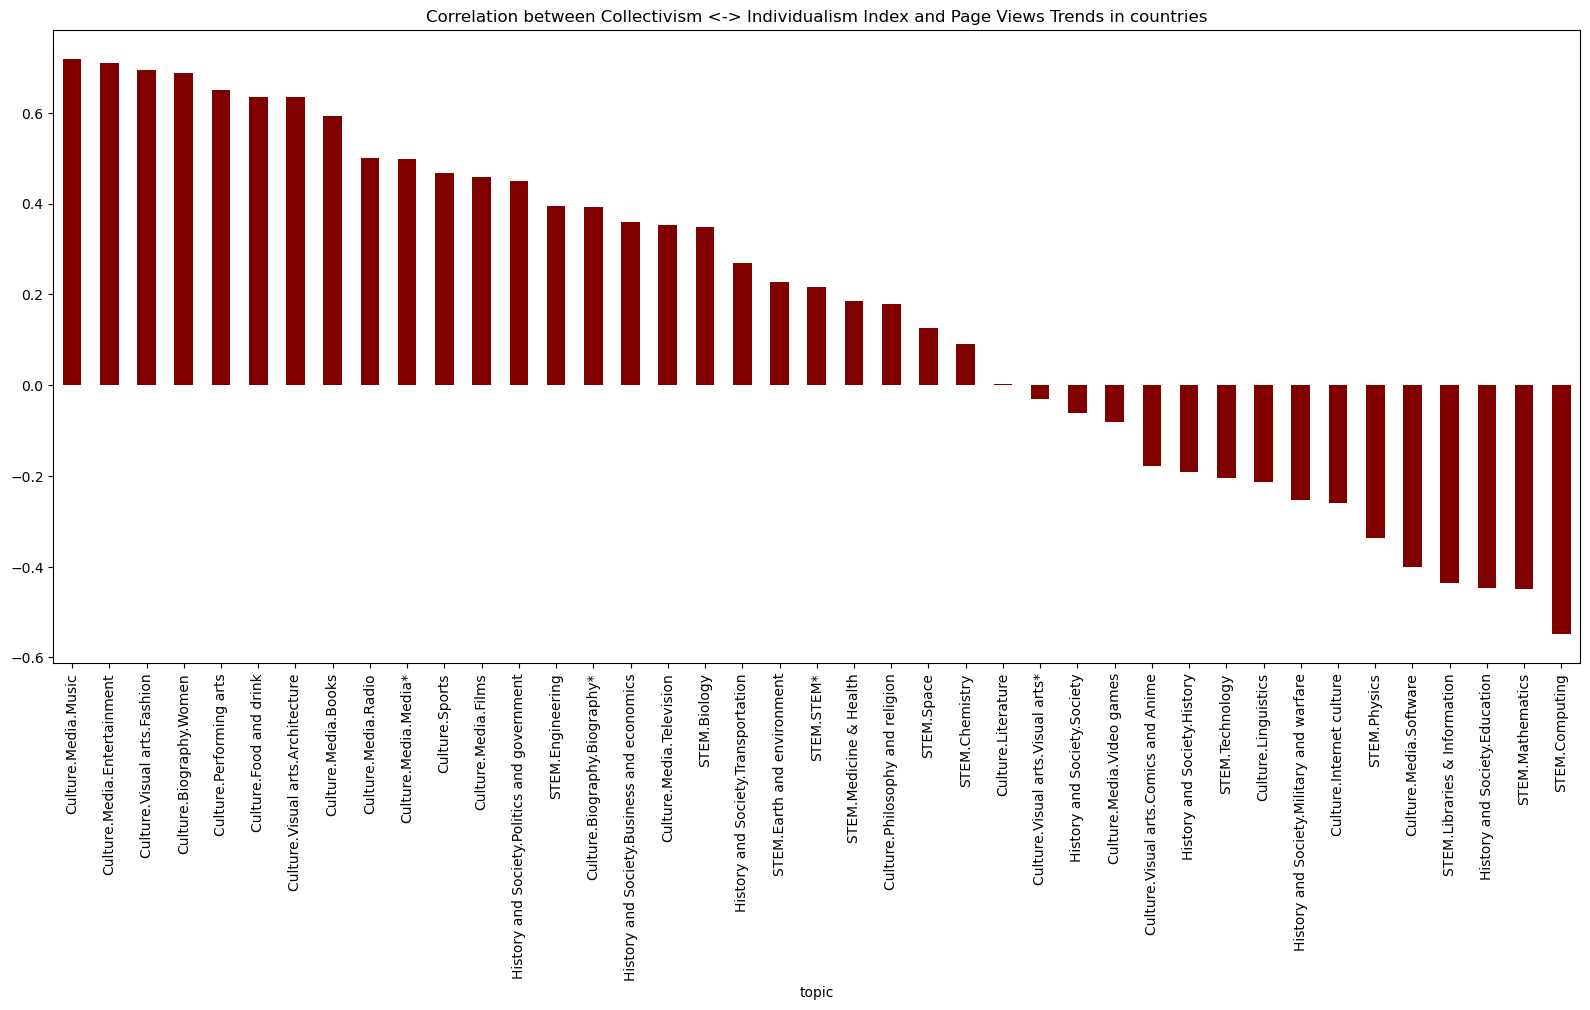

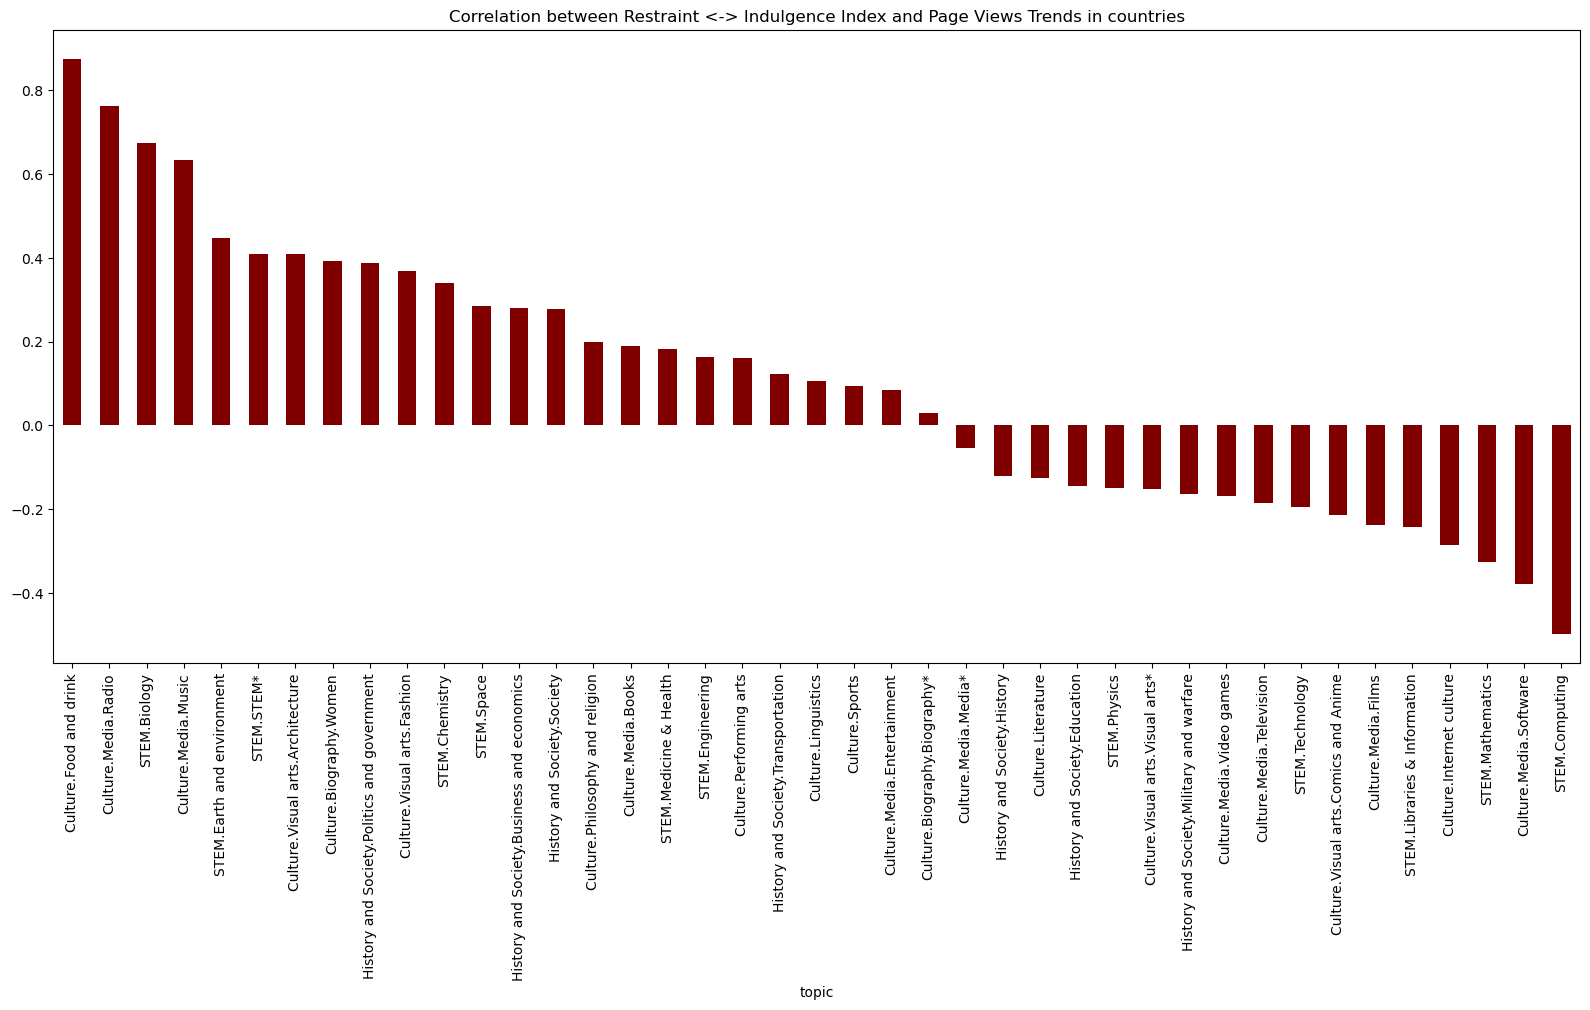

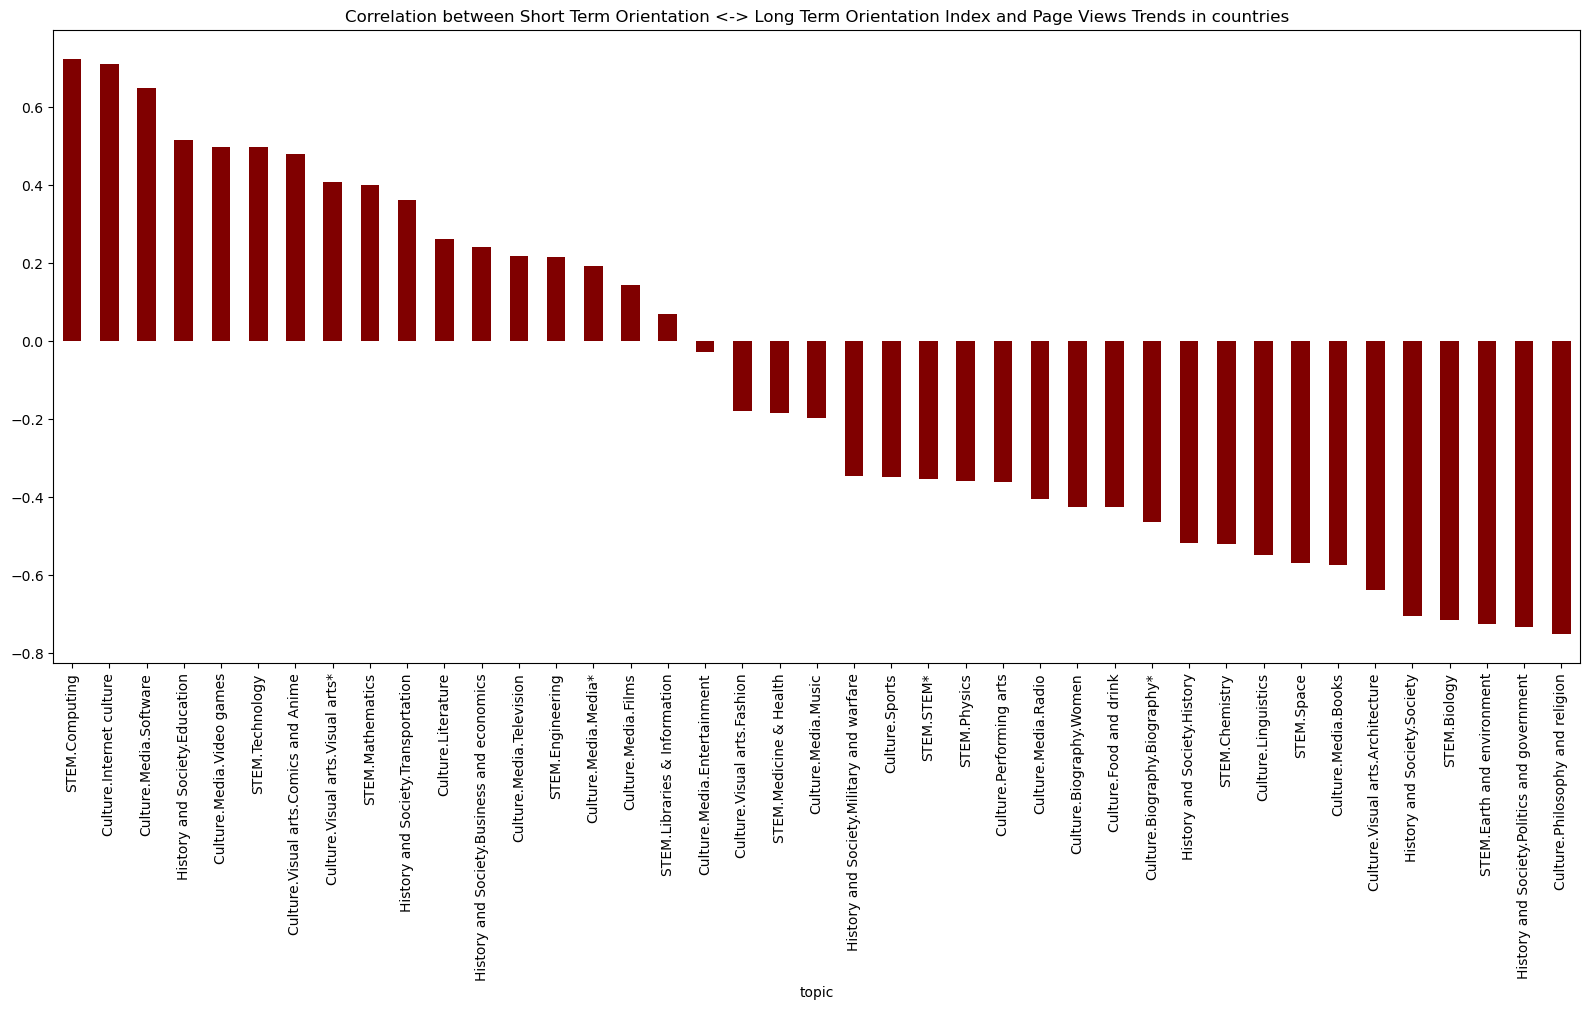

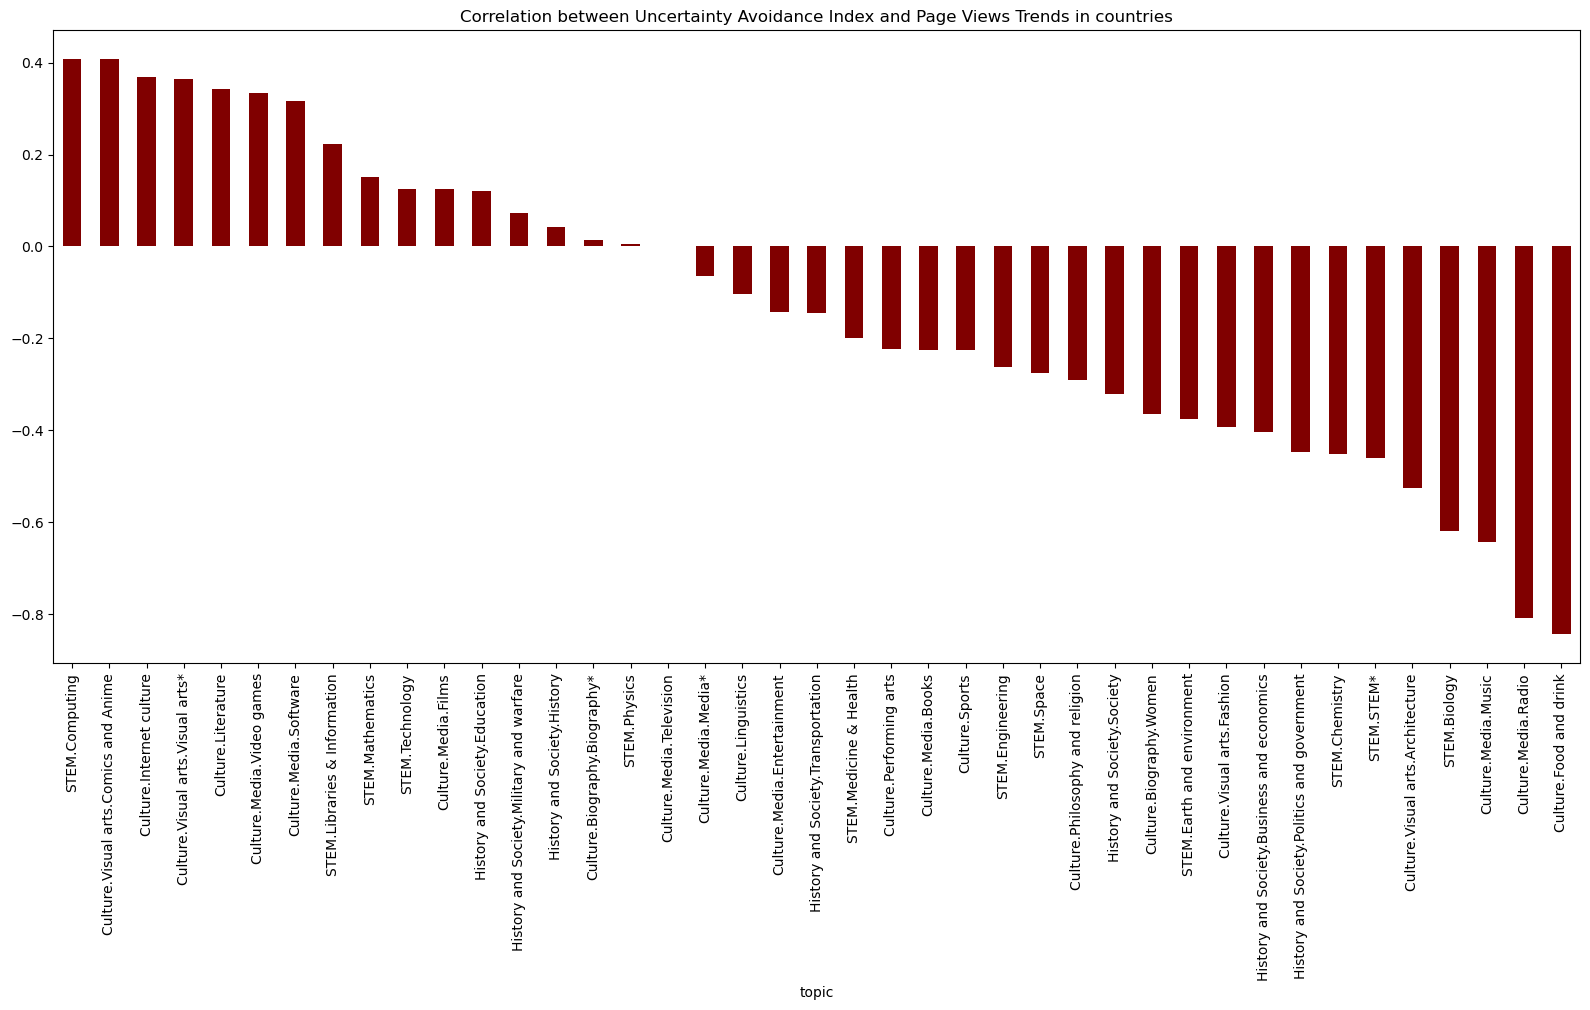

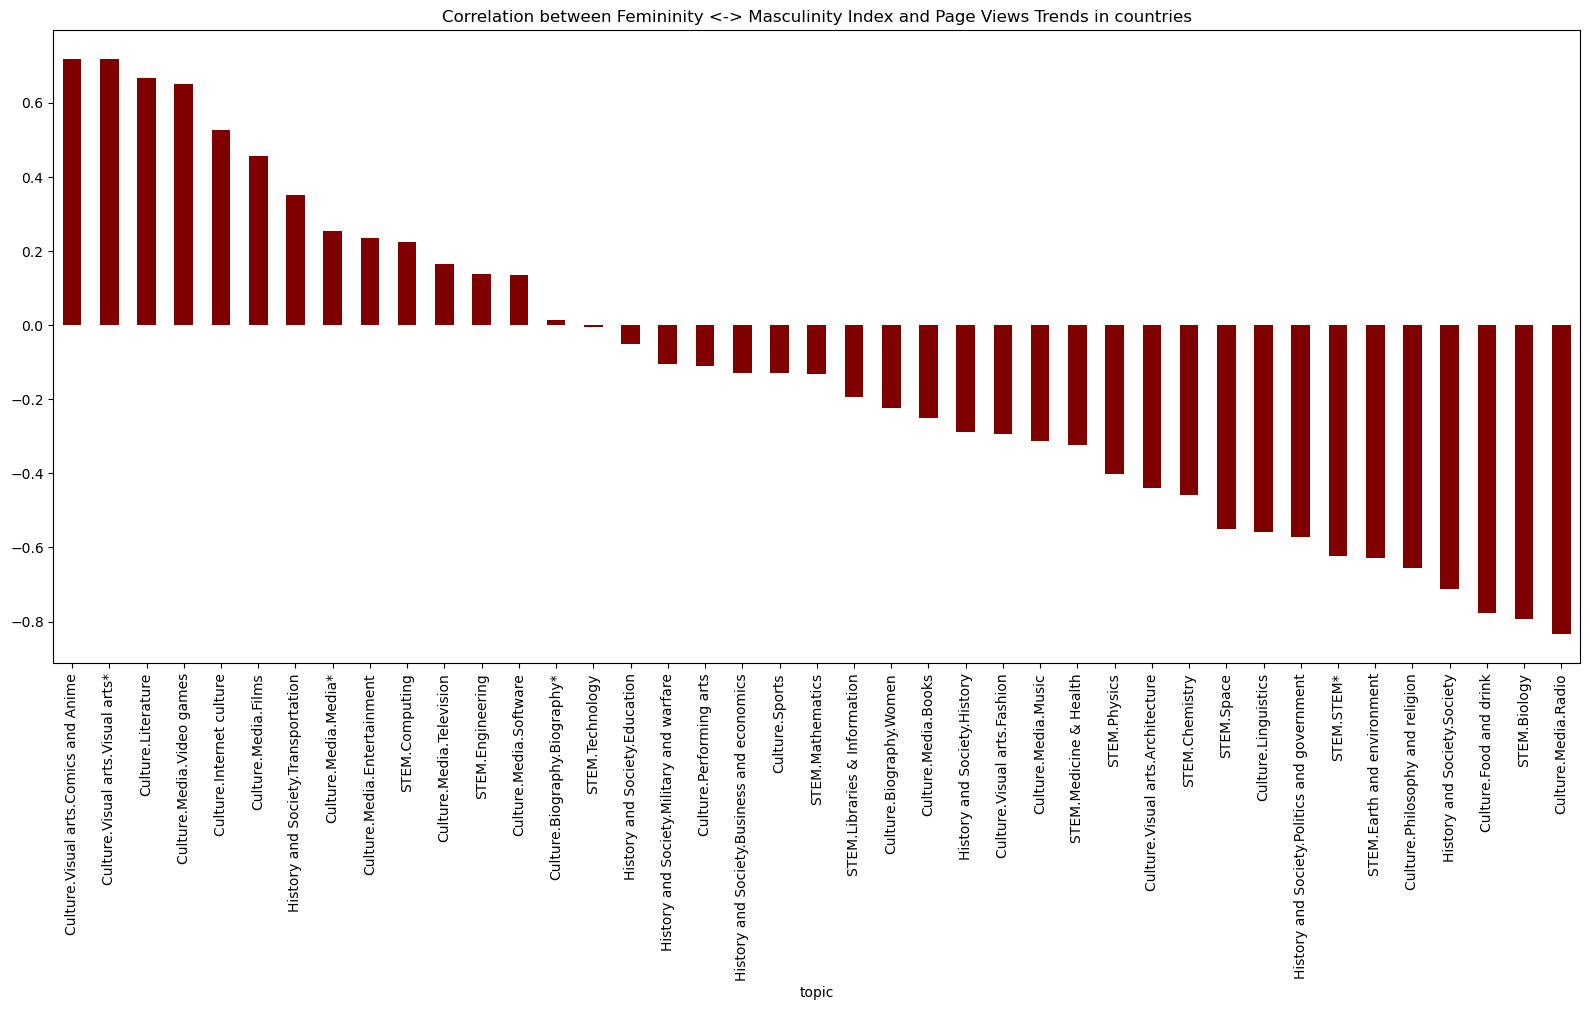

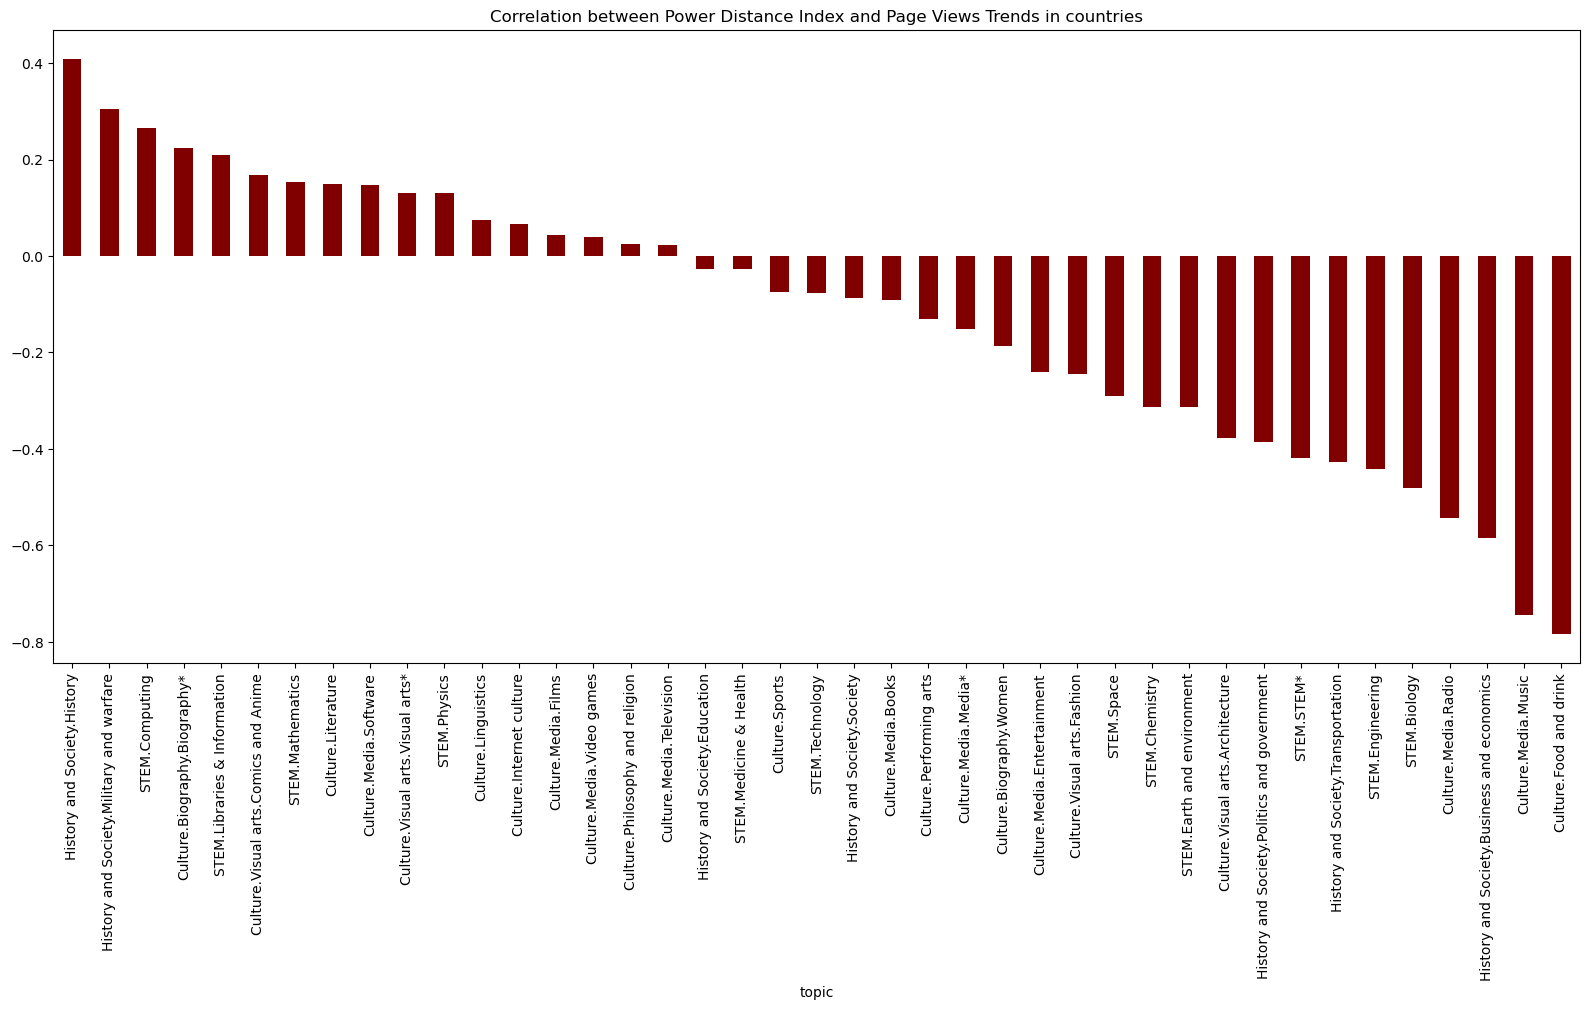

In [8]:
# Plot correlation between topics and hofstede cultural dimensions
dimensions = {'idv': 'Collectivism <-> Individualism Index', 'ivr' : 'Restraint <-> Indulgence Index', 'ltowvs' : 'Short Term Orientation <-> Long Term Orientation Index', 'uai': 'Uncertainty Avoidance Index', 'mas': 'Femininity <-> Masculinity Index', 'pdi': 'Power Distance Index'}
for dim, description in dimensions.items():
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    pre_covid_corr_df[dim].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
    fig.tight_layout()
    ax.set_title("Correlation between " + description + " and Page Views Trends in countries")

/Users/shivangsachar/anaconda3/envs/EPFL/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shivangsachar/anaconda3/envs/EPFL/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shivangsachar/anaconda3/envs/EPFL/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shivangsachar/anaconda3/envs/EPFL/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

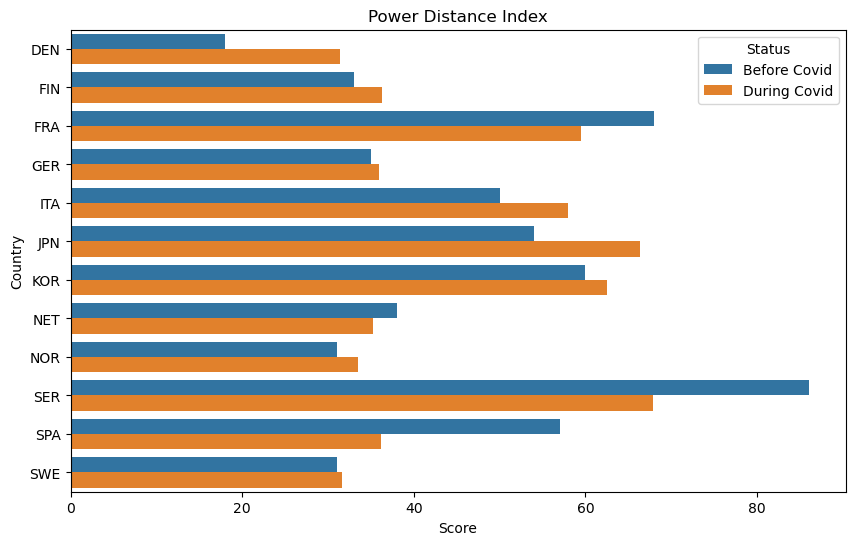

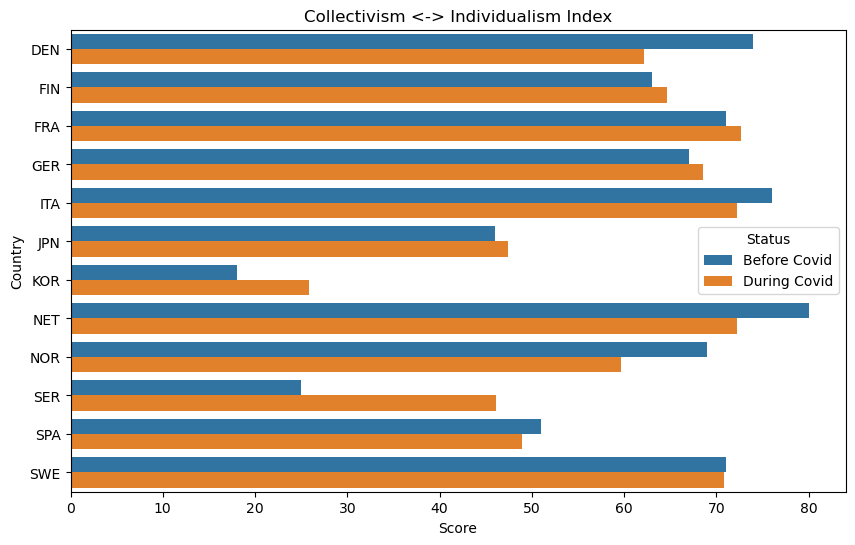

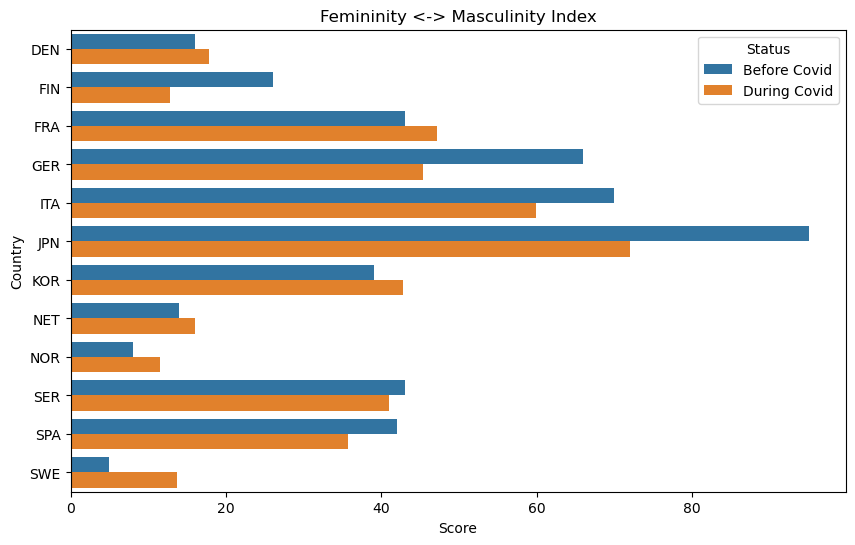

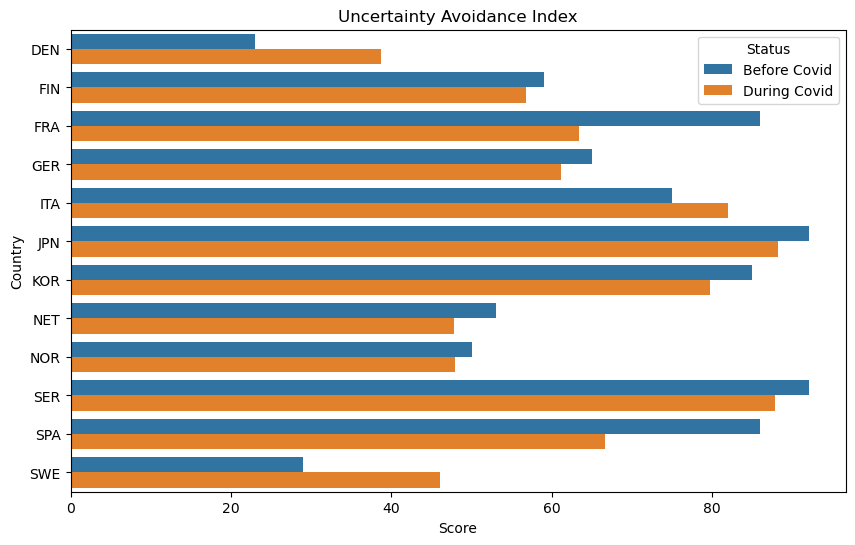

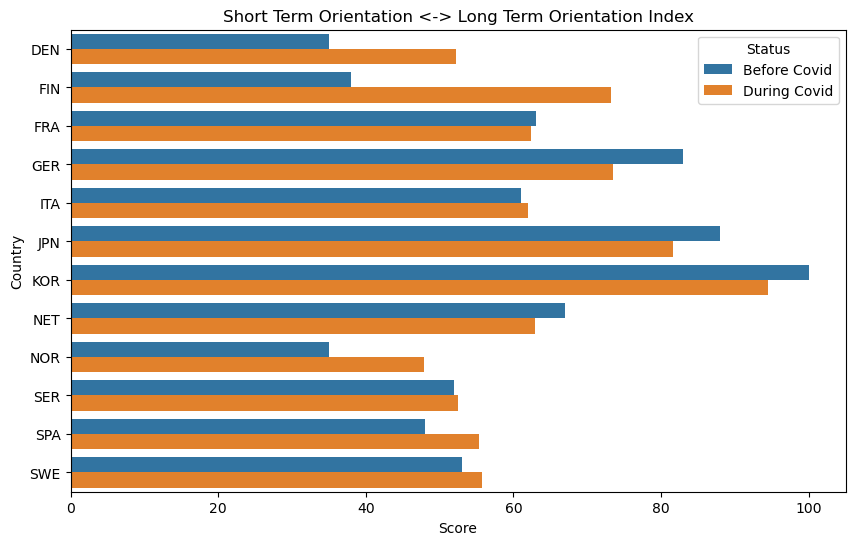

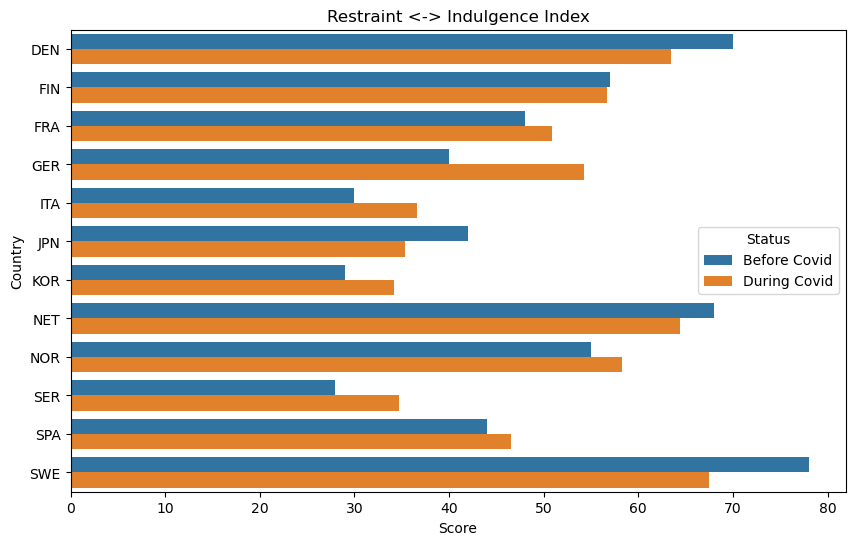

In [9]:
# Machine learning regression model to predict change in hofstede cultural dimension scores from change in pageview proportions
for dim in hofstede.columns:
    X = pre_covid_prop.pivot_table(index='language', columns='topic', values='median')
    X.index = X.index.map(code_dict)
    X = X.sort_index()
    X = X.rename_axis('ctr', axis='index')
    
    y = hofstede[dim]
    rf_regressor = RandomForestRegressor(n_estimators=15, random_state=42)
    rf_regressor.fit(X, y)
    
    # Remove uncorrelated features
    feature_importances = rf_regressor.feature_importances_
    threshold = 0.05
    features_to_remove = X.columns[feature_importances < threshold]
    X = X.drop(features_to_remove, axis=1)
    rf_regressor.fit(X, y)
    
    
    Xnew = dur_covid_prop.pivot_table(index='language', columns='topic', values='median')
    Xnew.index = Xnew.index.map(code_dict)
    Xnew = Xnew.sort_index()
    Xnew = Xnew.rename_axis('ctr', axis='index')
    Xnew = Xnew.drop(features_to_remove, axis=1)
    
    y_pred = rf_regressor.predict(Xnew)
    y_pred = pd.Series(y_pred, index=y.index)

    data = pd.DataFrame({
        'Country': list(y.index) * 2,
        'Score': list(y.values) + list(y_pred.values),
        'Status': ['Before Covid'] * len(y.index) + ['During Covid'] * len(y.index)
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y='Country', x='Score', hue='Status', data=data)
    plt.title(dimensions[dim])

### Create a proper dataset for ICT access and cluster countries according to their average ICT access

In [15]:
countries = ["Japan", "Germany", "France", "Italy", "Netherlands", "Sweden", "Italy", "Korea", "Finland", "Norway", "Denmark", "Türkiye"]
time = [2018, 2019, 2020]

df_ict_access = df_ict_access[(df_ict_access.Country.isin(countries)) & (df_ict_access.Time.isin(time)) &  (df_ict_access.Breakdowns.isin(["All (individuals aged 16-74)"]))]

# we are only interested in the columns 'Indicator' and its corresponding value (%age of people doing the thing stated in indicator)
df_ict_access = df_ict_access[['Country', 'Time', 'Indicator', 'Value']].reset_index(drop = True).groupby(["Indicator", "Country"])["Value"].mean().reset_index()

# pivot the dataset to have indictors as features and each row should represent a country
df_ict_access = df_ict_access.pivot(index='Country', columns='Indicator', values='Value').reset_index()

display(df_ict_access)

Indicator,Country,Individuals did not submit forms to public authorities: another person did it on their behalf - last 12 m (%),Individuals did not submit forms to public authorities: electronic signature/ID/certificate issues - last 12 m (%),Individuals did not submit forms to public authorities: lack of skills or knowledge - last 12 m (%),Individuals did not submit forms to public authorities: no need at all - last 12 m (%),Individuals did not submit forms to public authorities: no such website service available - last 12 m (%),Individuals did not submit forms to public authorities: personal data protection and security concerns - last 12 m (%),Individuals having caught a virus or other computer infection with impacts - last 3 m (%),Individuals having experienced a financial loss from fraudulent payment - last 3 m (%),Individuals having experienced a financial loss from phishing/pharming - last 3 m (%),...,Individuals who have transferred files - last 12 m (%),Individuals who have used basic arithmetic formulas in a spreadsheet - last 12 m (%),Individuals who have used software for electronic presentations (slides) - last 12 m (%),Individuals who have used spreadsheet advanced functions - last 12 m (%),Individuals who have used word processing software - last 12 m (%),Individuals who have written computer code - last 12 m (%),Individuals who managed access to personal data on the internet: read privacy policy statements before providing personal data,Individuals who managed access to their personal information on the Internet: limit access to their profile or content on social networking sites - last 12 m (%),Individuals who managed access to their personal information on the Internet: refuse allowing the use of personal information for advertising purposes - last 12 m (%),Individuals who managed access to their personal information on the Internet: restrict access to their geographical location - last 12 m (%)
0,Denmark,2.635433,0.5507,1.416467,18.228600,0.545167,0.780533,1.8010,5.6319,2.6275,...,61.038700,NaN,48.787900,33.6518,56.6225,14.29940,36.2914,48.8464,63.4918,62.2170
1,Finland,1.053700,0.4150,1.850067,20.711267,0.577633,0.592200,2.3801,1.7009,0.9368,...,66.125400,NaN,49.694300,33.7759,70.8274,9.85710,51.3691,56.7144,69.6703,69.4808
2,France,4.257500,NaN,5.572850,7.017450,0.602200,4.459950,2.8091,5.4020,1.5003,...,59.761000,NaN,35.125500,26.5214,54.0294,6.15770,NaN,NaN,NaN,NaN
3,Germany,4.457400,NaN,3.779933,49.861100,6.761133,6.802233,1.1222,0.9758,0.6284,...,65.647200,NaN,39.578200,33.2757,63.0665,5.94720,48.5005,40.0610,62.7896,54.8481
4,Italy,NaN,NaN,NaN,NaN,NaN,NaN,1.7752,1.8856,1.0389,...,36.116500,NaN,29.083700,21.4302,39.9203,5.84760,35.4762,24.3557,37.9534,31.3804
5,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Korea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.481389,47.341541,40.394773,NaN,NaN,7.21933,NaN,NaN,NaN,NaN
7,Netherlands,5.573800,0.1087,1.180967,23.854633,0.700167,0.976367,1.4825,2.1763,0.8004,...,68.350500,NaN,46.389500,36.1664,76.4952,9.54500,44.5076,62.6840,72.6136,74.9929
8,Norway,0.873633,0.5101,0.981333,20.947867,0.333967,0.446367,2.0550,4.3620,2.0873,...,66.496400,NaN,50.147300,30.2279,80.0602,11.66350,42.0789,36.8177,47.0046,56.8775
9,Sweden,1.173950,NaN,1.521300,13.195100,0.576333,0.560700,2.2794,3.2773,2.4690,...,52.866600,NaN,46.843100,29.0135,67.2962,11.89730,34.8613,40.3581,43.6355,57.8170


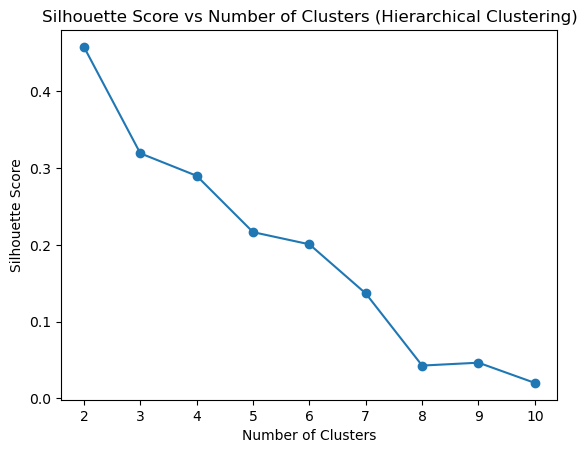

In [17]:
countries = df_ict_access['Country']
features = df_ict_access.drop('Country', axis=1)

imputer = SimpleImputer(strategy='median') # replace NaN with median value of the column 
features_imputed = imputer.fit_transform(features)

num_clusters_range = range(2, 11)
silhouette_scores = []

for num_clusters in num_clusters_range:
    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = agglomerative.fit_predict(features_imputed)
    silhouette_avg = silhouette_score(features_imputed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (Hierarchical Clustering)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.


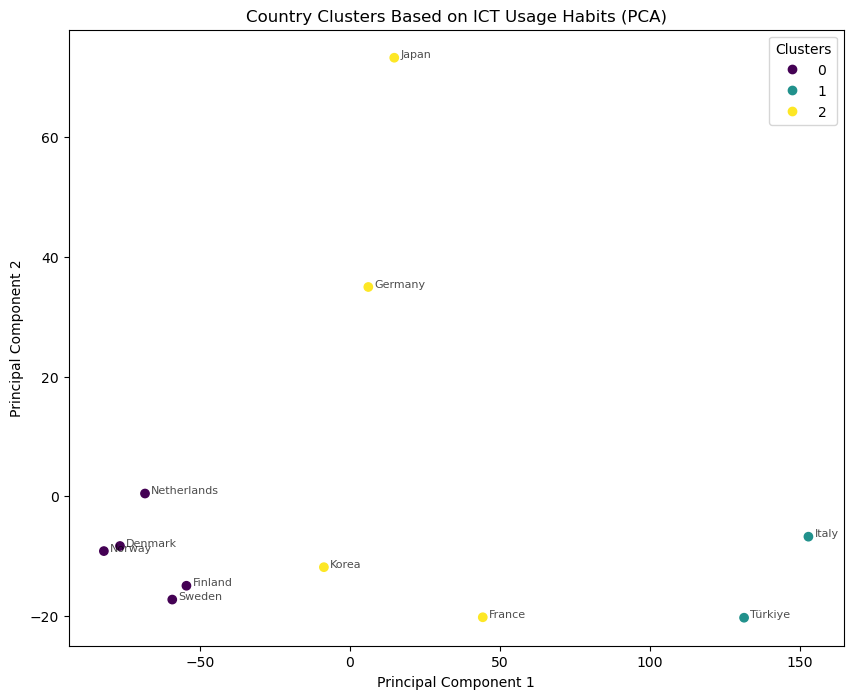

In [18]:
best_num_clusters = 3

kmeans = KMeans(n_clusters=best_num_clusters, random_state=42, n_init =10)
df_ict_access['Cluster'] = kmeans.fit_predict(features_imputed)
df_ict_access['Country'] = countries

cluster_labels = df_ict_access['Cluster'].values

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_imputed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')

for i, country in enumerate(df_ict_access['Country']):
    plt.annotate(country, (pca_result[i, 0] + 2, pca_result[i, 1]), fontsize=8, alpha=0.7)

# Add legend and labels

plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('Country Clusters Based on ICT Usage Habits (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.savefig('clusters_ict.png')

plt.show()

In [19]:
print(df_ict_access[['Country', 'Cluster']])

Indicator      Country  Cluster
0              Denmark        0
1              Finland        0
2               France        2
3              Germany        2
4                Italy        1
5                Japan        2
6                Korea        2
7          Netherlands        0
8               Norway        0
9               Sweden        0
10             Türkiye        1


Cluster 0: Denmark, Finland, Netherlands, Norway, Sweden

Cluster 1: Italy, Turkey

Cluster 2: France, Germany, Japan, Korea

### Cluster countries in groups with similar cultural interests

We will be able to see if the clusters retrieved as similar to the one retrieved just before

In [21]:
dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

for language in lang_codes:
    language_data = agg[language]
    language_data_mobile = agg[language + '.m']
    
    all_sum = pd.Series(language_data['sum']) + pd.Series(language_data_mobile['sum'])
    
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)

    for topic, topic_data in language_data["topics"].items():

        topic_data_mobile = language_data_mobile["topics"][topic]
        topic_sum = pd.Series(topic_data['sum']) + pd.Series(topic_data_mobile['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': pd.to_datetime(topic_sum.index),
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        dfs.append(topic_df)

df_timeseries_combined = pd.concat(dfs, ignore_index=True)
df_timeseries_combined.date = pd.to_datetime(df_timeseries_combined.date)

# Don't take into consideration the sub topics of metatopics (the ones that start with the same prefix as a metatopic)
topics_with_star = df_timeseries_combined[df_timeseries_combined['topic'].str.endswith('*')]['topic'].unique()
prefixes_to_remove = [topic.rsplit('.', 1)[0] for topic in topics_with_star]
df_timeseries_combined = df_timeseries_combined[~df_timeseries_combined['topic'].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes_to_remove)) | df_timeseries_combined['topic'].str.endswith('*')]

# The proportion of pageviews for a topic is equal to the median of all the pageview proportions over time
df_agg_combined = df_timeseries_combined.groupby(['language', 'topic']).agg({'proportion': 'median'}).reset_index()
df_agg_combined = df_agg_combined.pivot(index='language', columns='topic', values='proportion').reset_index()
display(df_agg_combined)

topic,language,Culture.Biography.Biography*,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Media*,Culture.Performing arts,Culture.Philosophy and religion,Culture.Sports,Culture.Visual arts.Visual arts*,History and Society.Business and economics,History and Society.Education,History and Society.History,History and Society.Military and warfare,History and Society.Politics and government,History and Society.Society,History and Society.Transportation,STEM.STEM*
0,ca,0.242141,0.018177,0.008450,0.019587,0.044514,0.112105,0.008758,0.050962,0.032663,0.034327,0.018307,0.004170,0.071107,0.028935,0.061554,0.035726,0.009051,0.199104
1,da,0.243265,0.022205,0.009942,0.012420,0.042001,0.156472,0.007290,0.045083,0.066513,0.035104,0.031510,0.004251,0.062919,0.036651,0.052633,0.033502,0.022762,0.184483
2,de,0.209940,0.020809,0.014242,0.010191,0.032907,0.192393,0.008615,0.034173,0.047819,0.029727,0.040415,0.004190,0.042247,0.042698,0.041626,0.027849,0.039198,0.218940
3,fi,0.197831,0.023721,0.015959,0.012309,0.039502,0.180217,0.005973,0.040048,0.059680,0.028570,0.034979,0.004454,0.042138,0.045929,0.045787,0.042385,0.027941,0.232603
4,fr,0.273405,0.018366,0.016202,0.009803,0.056476,0.226778,0.010117,0.041785,0.068344,0.045304,0.031899,0.004484,0.052720,0.035718,0.042293,0.028941,0.023351,0.171505
5,it,0.267238,0.015084,0.013272,0.008431,0.058060,0.263483,0.010419,0.043105,0.092320,0.048880,0.025819,0.002828,0.054009,0.030549,0.041871,0.023503,0.020301,0.149852
6,ja,0.219368,0.013368,0.022632,0.006426,0.104294,0.156995,0.003664,0.019066,0.056237,0.110218,0.024837,0.004438,0.019683,0.031178,0.016069,0.016344,0.037673,0.123200
7,ko,0.178752,0.016636,0.022220,0.012040,0.031578,0.160968,0.003942,0.034275,0.041477,0.027387,0.034748,0.008507,0.032176,0.027082,0.030184,0.029383,0.020188,0.186209
8,nl,0.218419,0.024536,0.011252,0.011263,0.033615,0.162272,0.006360,0.042247,0.072816,0.034178,0.029417,0.003733,0.051268,0.033737,0.040522,0.029197,0.023204,0.200266
9,no,0.235861,0.022547,0.009666,0.015858,0.038221,0.141905,0.006969,0.048151,0.078811,0.025489,0.029345,0.004419,0.058811,0.041400,0.049643,0.035145,0.027552,0.191729


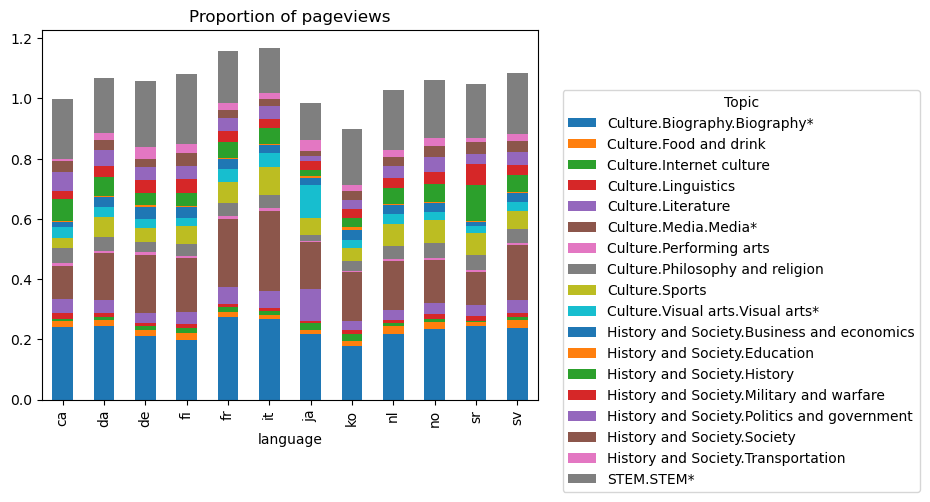

In [22]:
df_agg_combined.plot.bar(x='language', stacked=True, title='Proportion of pageviews')
plt.legend(title='Topic', loc=(1.05,-0.25)) 
plt.savefig('proportions.png')

/var/folders/dk/9nh99bzj6wz3m_x2kc85v7y80000gn/T/ipykernel_84651/158023040.py:6: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  df_agg_combined.plot.bar(x='language', stacked=True, colormap=plt.cm.viridis, title='Proportion of pageviews', color=colors)
/var/folders/dk/9nh99bzj6wz3m_x2kc85v7y80000gn/T/ipykernel_84651/158023040.py:6: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  df_agg_combined.plot.bar(x='language', stacked=True, colormap=plt.cm.viridis, title='Proportion of pageviews', color=colors)


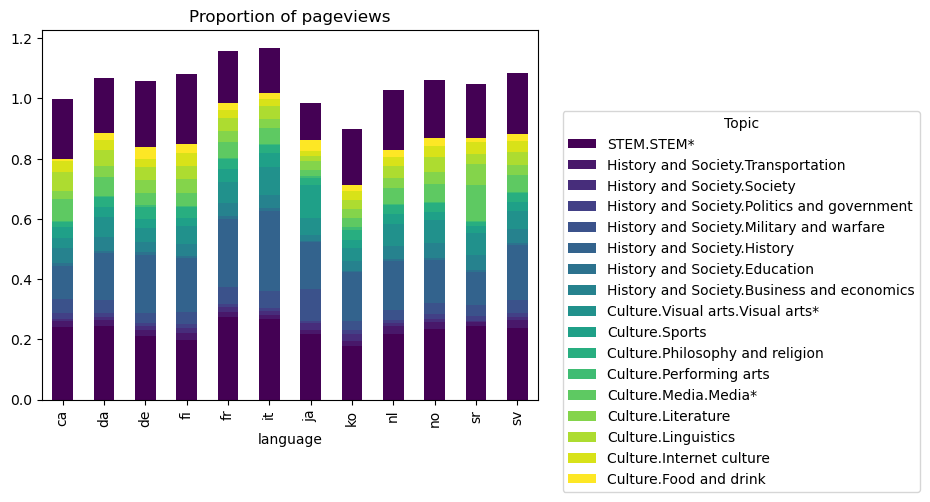

In [23]:
# Get unique topics and assign a color to each
unique_topics = df_agg_combined.columns[2:]
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_topics)))

# Plot the stacked bar chart
df_agg_combined.plot.bar(x='language', stacked=True, colormap=plt.cm.viridis, title='Proportion of pageviews', color=colors)
plt.legend(title='Topic', loc=(1.05,-0.25), labels=unique_topics[::-1])